# 02. Разности

In [15]:
import numpy as np
import pandas as pd
import polars as pl
import bottleneck as bn

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

# настройка визуализации
%config InlineBackend.figure_format = 'retina'

# импорт необходимых классов и функций
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [16]:
file = 'Data/example.csv'
data = pd.read_csv(file, sep='\t')
data.head()

,date,sales
0,09.01.2018,2400
1,10.01.2018,2800
2,11.01.2018,2500
3,12.01.2018,2890
4,13.01.2018,2610


**Можно создавать разности между значениями сооответствующего лага**:
+ разница между продажими на прошлой неделе и продажами на позапрошлой неделе
+ разница между продажами на прошлой неделе и продажами четыремя неделями раньше

Сгенерируем:
+ лаги 3, 4, 5
+ разности в 1 и 2 периоде на основе лагов

In [17]:
# создаем лаги
lags = [3,4,5]

for lag in lags:
    data[f'Lag{lag}'] = data['sales'].shift(lag)
data.head(10)

,date,sales,Lag3,Lag4,Lag5
0,09.01.2018,2400,NaN,NaN,NaN
1,10.01.2018,2800,NaN,NaN,NaN
2,11.01.2018,2500,NaN,NaN,NaN
3,12.01.2018,2890,2400.0,NaN,NaN
4,13.01.2018,2610,2800.0,2400.0,NaN
5,14.01.2018,2500,2500.0,2800.0,2400.0
6,15.01.2018,2750,2890.0,2500.0,2800.0
7,16.01.2018,2700,2610.0,2890.0,2500.0
8,17.01.2018,2250,2500.0,2610.0,2890.0
9,18.01.2018,2350,2750.0,2500.0,2610.0


In [18]:
# создаем разности на основе лагов
for lag in lags:
    data[f'Diff_on_Lag{lag}'] = data[f'Lag{lag}'].diff()

data['Diff2_on_Lag4'] = data['Lag4'].diff(2)
data['Diff2_on_Lag5'] = data['Lag5'].diff(2)

In [14]:
data

,date,sales,Lag3,Lag4,Lag5,Diff_on_Lag3,Diff_on_Lag4,Diff_on_Lag5,Diff2_on_Lag4,Diff2_on_Lag5
0,09.01.2018,2400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10.01.2018,2800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11.01.2018,2500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12.01.2018,2890,2400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,13.01.2018,2610,2800.0,2400.0,NaN,400.0,NaN,NaN,NaN,NaN
5,14.01.2018,2500,2500.0,2800.0,2400.0,-300.0,400.0,NaN,NaN,NaN
6,15.01.2018,2750,2890.0,2500.0,2800.0,390.0,-300.0,400.0,100.0,NaN
7,16.01.2018,2700,2610.0,2890.0,2500.0,-280.0,390.0,-300.0,90.0,100.0
8,17.01.2018,2250,2500.0,2610.0,2890.0,-110.0,-280.0,390.0,110.0,90.0
9,18.01.2018,2350,2750.0,2500.0,2610.0,250.0,-110.0,-280.0,-390.0,110.0


Разобъем набор данных так, чтобы в тестовую выборку попало **4 последних наблюдения**:
+ горизонт прогнозирования - 4 дня

In [21]:
HORIZON = 4
train, test = data[0:data.shape[0]-HORIZON], data[data.shape[0]-HORIZON:]
display('train', train)
display('test', test)                

'train'

,date,sales,Lag3,Lag4,Lag5,Diff_on_Lag3,Diff_on_Lag4,Diff_on_Lag5,Diff2_on_Lag4,Diff2_on_Lag5
0,09.01.2018,2400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10.01.2018,2800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11.01.2018,2500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12.01.2018,2890,2400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,13.01.2018,2610,2800.0,2400.0,NaN,400.0,NaN,NaN,NaN,NaN
5,14.01.2018,2500,2500.0,2800.0,2400.0,-300.0,400.0,NaN,NaN,NaN
6,15.01.2018,2750,2890.0,2500.0,2800.0,390.0,-300.0,400.0,100.0,NaN
7,16.01.2018,2700,2610.0,2890.0,2500.0,-280.0,390.0,-300.0,90.0,100.0


'test'

,date,sales,Lag3,Lag4,Lag5,Diff_on_Lag3,Diff_on_Lag4,Diff_on_Lag5,Diff2_on_Lag4,Diff2_on_Lag5
8,17.01.2018,2250,2500.0,2610.0,2890.0,-110.0,-280.0,390.0,110.0,90.0
9,18.01.2018,2350,2750.0,2500.0,2610.0,250.0,-110.0,-280.0,-390.0,110.0
10,19.01.2018,2550,2700.0,2750.0,2500.0,-50.0,250.0,-110.0,140.0,-390.0
11,20.01.2018,3000,2250.0,2700.0,2750.0,-450.0,-50.0,250.0,200.0,140.0


Видим, что возникает **протечка** данных:
+ столбец `Diff_on_Lag3` в test - использует информацию **тестовой** выборки
+ в других столбцах протечки нет
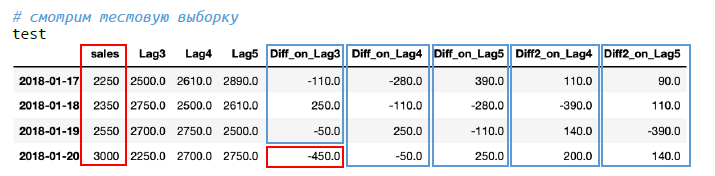